In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

--2021-11-30 22:43:33--  https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300965906 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.0-bin-hadoop3.2.tgz’

spark-3.2.0-bin-had 100%[===================>] 287.02M   163MB/s    in 1.8s    

2021-11-30 22:43:35 (163 MB/s) - ‘spark-3.2.0-bin-hadoop3.2.tgz’ saved [300965906/300965906]



In [ ]:
!tar xvzf spark-3.2.0-bin-hadoop3.2.tgz

In [4]:
!ls /content/spark-3.2.0-bin-hadoop3.2

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [5]:
# Set the ‘environment’ path
import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [6]:
!pip install -q findspark

import findspark
findspark.init()

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder\
    .master("local[*]")\
    .appName("final-project")\
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [ ]:
sc

<SparkContext master=local[*] appName=final-project>

In [9]:
#The wildfire location database 
locatData = spark.read.option("header",True) \
.option("inferSchema", True) \
.csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")

In [10]:
#locTime will be used to focus on the frequency of wildfires per state
#POOState - Location of wildfire at time of discovery
#FireDiscoveryDateTime - Date when the fire was discovered.
locTime = locatData.select(substring(locatData["POOState"],4,6).alias("State Occurred"),
                           substring(locatData['FireDiscoveryDateTime'],0,4).alias("Year"))

In [ ]:
#Unusable rows are filtered out.
locTime = locTime.filter((locTime["year"].isNotNull())& (locTime["State Occurred"].isNotNull()))\

In [ ]:
#A significant difference between the wildfire frequency was found between 2013 and 2014; it is assumed the years before 2014 had incomplete data.
locTime.groupBy("Year").count().orderBy("year").show()


+----+-----+
|Year|count|
+----+-----+
|2003|    1|
|2004|    1|
|2008|    3|
|2009|   18|
|2010|    7|
|2011|   20|
|2012|    4|
|2013|   16|
|2014|12675|
|2015|19796|
|2016|20252|
|2017|25686|
|2018|23962|
|2019|29239|
|2020|35640|
|2021|37195|
+----+-----+



In [ ]:
locTime = locTime.filter(locTime["Year"] > 2013)

In [ ]:
#The table below shows the frequency of Fires for each state; the visualization is still being worked on.
stateOccur = locTime.filter(locTime["year"].isNotNull())\
.groupBy("year").pivot("State Occurred").count().orderBy("year")
stateOccur = stateOccur.na.fill(value=0)
stateOccur.show()

+----+---+---+---+----+---+---+---+-----+---+----+---+---+---+----+---+---+---+---+----+---+---+---+---+---+---+---+----+---+----+---+---+----+---+----+---+---+---+----+---+---+---+---+----+---+---+---+---+---+---+---+---+---+----+----+---+---+----+---+---+----+---+
|year| AK| AL| AR|  AZ| BC|BCN| BN|   CA| CH|  CO| CT| DC| DE|  FL| GA| GU| HI| IA|  ID| IL| IN| KS| KY| LA| MA| MD|  ME| MI|  MN| MO| MS|  MT| NC|  ND| NE| NH| NJ|  NM| NV| NY| OH| OK|  OR| PA| PR| SC| SD| SK| SO|SON|TAM| TN|  TX|  UT| VA| VT|  WA| WI| WV|  WY| YT|
+----+---+---+---+----+---+---+---+-----+---+----+---+---+---+----+---+---+---+---+----+---+---+---+---+---+---+---+----+---+----+---+---+----+---+----+---+---+---+----+---+---+---+---+----+---+---+---+---+---+---+---+---+---+----+----+---+---+----+---+---+----+---+
|2014|377| 32| 15| 948|  0|  0|  0| 2106|  0| 619|  0|  0|  0| 183| 25|  0|  2|  4| 993|  3|  0|  4| 21| 44|  0|  3|   1| 66| 115|  7| 65| 840| 49| 235| 12|  2|  2| 517|529| 10| 12|109|2164| 16| 28| 

In [11]:
#The Data in this csv primarily tracks the area of each recorded fire.
perimData = spark.read.option("header",True) \
.option("inferSchema", True) \
.csv("WFIGS_-_Wildland_Fire_Perimeters_Full_History.csv")

In [55]:
#perimTime will be used to focus on the area damaged by wildfires, per state and overall
#The dataset only shows signficant data from 2019 onwards, so analysis will be month by month.
perimTime = perimData.select(substring(perimData["irwin_POOState"],4,6).alias("State Occurred"),
                             perimData["poly_Acres_AutoCalc"].alias("area(acres)"),
                             substring(perimData['irwin_ContainmentDateTime'],0,4).alias("year"),
                             substring(perimData['irwin_ContainmentDateTime'],6,2).alias("month"),
                             substring(perimData['irwin_ContainmentDateTime'],0,7).alias("year/month"))
perimTime = perimTime.filter(perimTime["year"].isNotNull())


In [56]:
#Used for analysis of total area burned by wildfires across the  US
overallAffected = perimTime.groupBy("year/month").agg(sum('area(acres)').alias("area (acres)")).orderBy("year/month")

In [57]:

overallAffected.show()

+----------+------------------+
|year/month|      area (acres)|
+----------+------------------+
|   2018/06|  1.70988672404488|
|   2018/08|0.0232932508259032|
|   2019/10|  42.2824011427289|
|   2019/11|  11.1249207256351|
|   2019/12| 0.384916101758091|
|   2020/01|1333.3562204796733|
|   2020/02| 5574.576917562359|
|   2020/03|23299.046849063558|
|   2020/04| 18463.69067194689|
|   2020/05| 82474.71160321498|
|   2020/06| 198061.4936478917|
|   2020/07|  833440.703834384|
|   2020/08| 530746.8560419319|
|   2020/09|1476742.5169804976|
|   2020/10| 853609.8450898579|
|   2020/11|1484642.5787928682|
|   2020/12|1618261.3825070355|
|   2021/01| 199445.1516883008|
|   2021/02| 9296.490508084951|
|   2021/03| 109923.9058066683|
+----------+------------------+
only showing top 20 rows



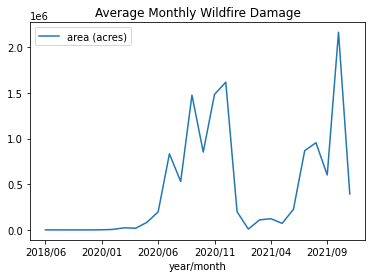

In [59]:
#Will work on the x-axis
plt1 = overallAffected.toPandas()
plt1.plot(
    x="year/month",
    y = "area (acres)",
    title = "Average Monthly Wildfire Damage")


In [26]:
#Used for analysis of area affected by state.
#Visualization needs to be worked on.
stateAffected = perimTime.groupBy("year/month").pivot("State Occurred").mean().orderBy("year/month")
stateAffected = stateAffected.na.fill(value=0)

In [28]:
stateAffected.show()

+----------+-------------------+-------------------+------------------+------------------+--------------------+----------------+------------------+-------------------+------------------+----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---+------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+----------------+------------------+-----------------+---+------------------+
|year/month|                 AK|                 AL|                AR|                AZ|                  CA|        

In [ ]:
#Considering wildfire cost as another possible property to analyze
costTime = perimData.select(substring(perimData["irwin_POOState"],4,6).alias("State Occurred"),perimData["irwin_EstimatedCostToDate"].alias("cost"),substring(perimData['irwin_ContainmentDateTime'],0,7).alias("year/month"))
costTime = costTime.filter(costTime["year/month"].isNotNull())

In [ ]:
costByYear = costTime.groupBy("year/month").pivot("State Occurred").sum().orderBy("year/month")

In [ ]:
#visualization needs to be worked on.
costByYear = costByYear.na.fill(value=0)
costByYear.show()

+-------+---------+-------+-------+--------------------+------------+---+-----------+---------+---+---+---+-----------+---+---+--------+-------+-------+---+---+-------+--------+-------+-------+-----------+-------+-------+-------+---+---+---------+-----------+---+------+--------+--------------+---+---+--------+--------+------+-----------+-------+---+-------------+---+---+---------+
|   year|       AK|     AL|     AR|                  AZ|          CA| CH|         CO|       FL| GA| HI| IA|         ID| IL| IN|      KS|     KY|     LA| MA| ME|     MI|      MN|     MO|     MS|         MT|     NC|     ND|     NE| NH| NJ|       NM|         NV| NY|    OH|      OK|            OR| PA| SC|      SD|      TN|    TX|         UT|     VA| VT|           WA| WI| WV|       WY|
+-------+---------+-------+-------+--------------------+------------+---+-----------+---------+---+---+---+-----------+---+---+--------+-------+-------+---+---+-------+--------+-------+-------+-----------+-------+-------+-------+---